In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [2]:
DATA = r"C:\Users\User\Documents\GitHub\work\practical-statistics-for-data-scientists\data\\"
WEB_PAGE_DATA_CSV = DATA + 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA + 'four_sessions.csv'
CLICK_RATE_CSV = DATA + 'click_rates.csv'
IMANISHI_CSV = DATA + 'imanishi_data.csv'

In [3]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


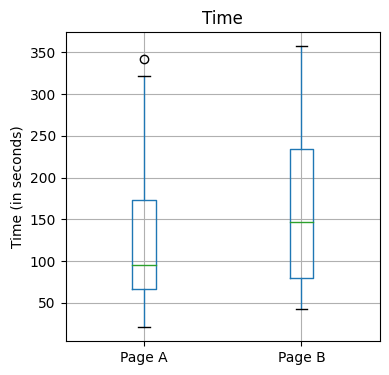

In [4]:
ax = session_times.boxplot(by='Page', column='Time', figsize=(4,4))

ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()


In [5]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


In [6]:
def perm_fun(x, nA, nB):
    #функция которая отбирает рандомные числа из масива и 
    #возвращает разницу средних (отклонение) в соответствии с размерами выборок
    n = nA +nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
#находим размер выборок по группам
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-37.704761904761895


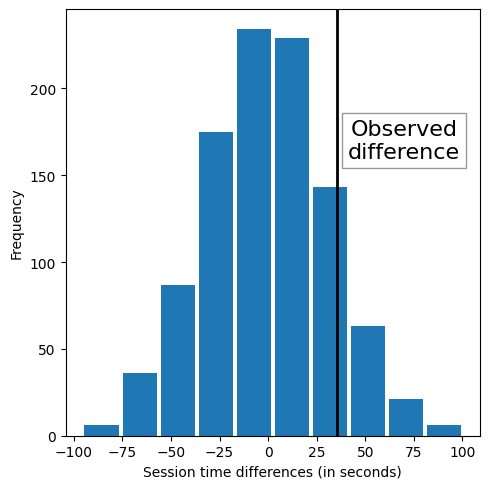

In [7]:
#сделаем распределение данных отклонений после пермутации
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs,  bins=10, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(70,170, 'Observed\ndifference', bbox={"facecolor":'white', "alpha":0.4},
        verticalalignment='center', horizontalalignment='center', fontsize=16)
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
perm_diffs = np.array(perm_diffs)
print(np.mean(perm_diffs > mean_b - mean_a))
print(np.mean([diff > mean_b - mean_a for diff in perm_diffs]))
#доля случайных разниц превышающих наблюдаемую нами, 12,1%

0.121
0.121


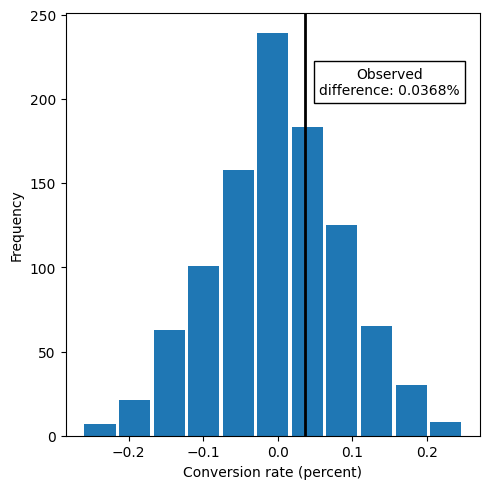

In [9]:
random.seed(1)
#дано две цены (А,В), и хорошие это при покупке из всех
A_good, B_good = 200, 182
A_all, B_all = 23739, 22588
obs_pct_diff = 100 * (A_good/A_all - B_good / B_all)
conversion = [0]*(A_all + B_all-A_good-B_good)
conversion.extend([1]*(A_good+B_good))# делаем список из 0 и 1 неудач и успехов
conversion = pd.Series(conversion)

perm_diffs = [100*perm_fun(conversion, A_all, B_all) for _ in range(1000)]
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(obs_pct_diff, color='black', lw=2)
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')
ax.text(0.15,210,f'Observed\ndifference:{obs_pct_diff: .4f}%',
         bbox=dict(facecolor='white'), horizontalalignment='center',
         verticalalignment='center')



plt.tight_layout()
plt.show()

In [10]:
#считаем p значение честно
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))
#доля правдивых случаев, то есть в 33,2% случайность превышает наблюдаемую разницу

0.332


In [11]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)
#считаем p значения опраксимируя как нормальное распределение
print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


In [12]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


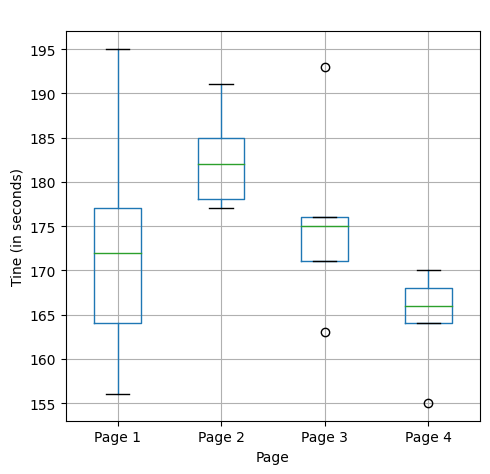

In [33]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time', figsize=(5,5))

ax.set_xlabel('Page')
ax.set_ylabel('Tine (in seconds)')
plt.title(' ')
plt.suptitle('')

plt.tight_layout()
plt.show()


In [69]:
#дисперсия между группами, [0] чтобы лучше отображалось
observed_variance = four_sessions.groupby('Page').mean().var()[0]
#Распаковываем среднием значения по группам с помощью ravel() по очереди
print(f'Observed means: ',four_sessions.groupby('Page').mean().values.ravel())
print('Variance: ', observed_variance)

def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
print(perm_test(four_sessions))


Observed means:  [172.8 182.6 175.6 164.6]
Variance:  55.426666666666655
31.426666666666748
